In [1]:
import warnings; warnings.simplefilter('ignore')

import numpy as np 
import pandas as pd 
import os

# For graphs and node2vec
import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec

pd.options.mode.chained_assignment = None

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan


# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# To perform PCA
from sklearn.decomposition import PCA

# To perform t-SNE
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

# To perform DBSCAN
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
pd.options.mode.chained_assignment = None

Importing the cleaned file generated and saved from the previous notebook

In [2]:
# Reading the final cleaned dataset
site_data = pd.read_csv('filtered_dataset.csv')

In [3]:
site_data.head()

,from_url,to_url,user_count
0,youtube.com,google.com,212049
1,indianapublicmedia.org,wfiu.org,188708
2,drudgereport.com,google.com,57304
3,google.com,boost.org,49318
4,google.com,bio.net,43976


In [4]:
site_data.shape

(9729, 3)

**EDA on the dataset**

Before beginning with the modelling, it's important to understand what the data looks like. Firstly, looking at the distribution of hits by websites to identify if we are seeing any websites skewing the data here

In [5]:
# Hits per website
x = site_data[['from_url', 'user_count']]
x.columns = ['website', 'hits']

y = site_data[['to_url', 'user_count']]
y.columns = ['website', 'hits']

#combining the 2 datasets
website_hits = pd.concat([x, y])

#aggregating the websites to get sum of total hits
website_hits = pd.DataFrame(website_hits.groupby("website")['hits'].sum()).reset_index().sort_values(by = "hits", ascending = False)

In [6]:
website_hits.head()

,website,hits
2842,google.com,1183583
7489,youtube.com,566522
2268,facebook.com,499001
2887,gravatar.com,228785
3337,indianapublicmedia.org,203715


In [7]:
# Looking at the statistical summary of the hits column
website_hits.describe()

,hits
count,7.553000e+03
mean,1.064247e+03
std,1.697400e+04
min,5.100000e+01
25%,7.400000e+01
50%,1.390000e+02
75%,3.410000e+02
max,1.183583e+06


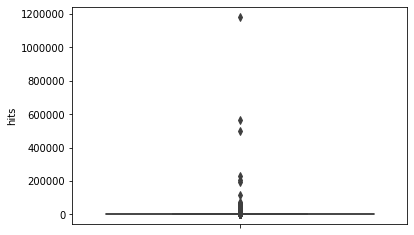

In [8]:
# Plotting a box plot of hits by websites to get an idea of the existing outliers
sns.boxplot(y='hits',data=website_hits)

We observe that there are a small number of websites that have a very large audience pool, which can be considered as outliers. Let's have a look at what these websites are:

Text(0.5, 0, 'Websites')

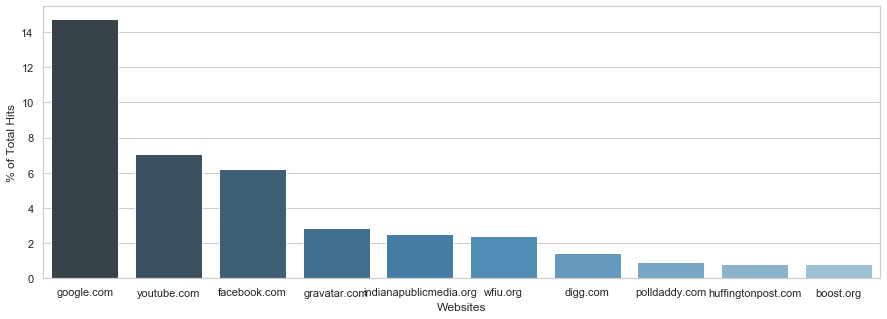

In [9]:
# Filtering out the top 10 websites
x = website_hits.sort_values(by = "hits", ascending=False).head(10)
tmp = sum(website_hits['hits'])
x['share_hits'] = x['hits'].apply(lambda t: t*100/tmp)

plt.figure(figsize=(15, 5))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x['website'],x['share_hits'], palette='Blues_d')
plt.ylabel('% of Total Hits' )
plt.xlabel('Websites')


We observe that Google, Youtube and Facebook capture approx. a quarter of the total hits on all websites in the dataset.<br><br>
From the box plot, it is tough to get an idea of the distribution of the hits as we have some really massive outliers. In order to understand the distribution of the data, the hits will be plotted on a log-scale.

Text(0.5, 1.0, 'Log Distribution of Hits')

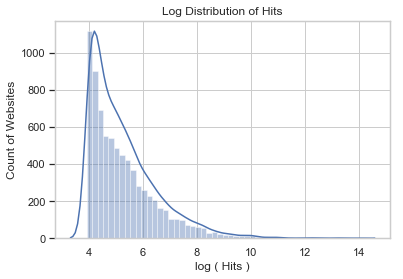

In [10]:
# Plotting the disrtribution of the data in a log scale

data = website_hits['hits']
# Plotting hist without kde
ax = sns.distplot(np.log(data), kde=False)
plt.ylabel('Count of Websites' )
plt.xlabel('log ( Hits )')
# Creating another Y axis
second_ax = ax.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(np.log(data), ax=second_ax, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax.set_yticks([])

plt.title('Log Distribution of Hits')


There will be no sort of outlier removal needed in our case, as these outliers are a true representation of the user behaviour online. We would want our model to be inclusive of these outliers, and the vectors created for all websites to be representative of the high website share occupied by these websites

**Transforming the data into a graph format**

First, let's visualize what a graph for a set of websites connected to "google.com" look like

In [11]:
# Visualizing a sample graph with the central node as google.com
google_graph = site_data.loc[site_data['from_url']=="google.com",:].head(20)
#site_graph = nx.from_pandas_edgelist(google_graph, source= 'from_url', target= 'to_url', edge_attr= 'user_count')
#site_graph = nx.relabel_nodes(site_graph, dict(enumerate(df2.columns)))

In [12]:
# Creating a list of all the websites in the dataset, this will be the nodes of the graph.

ls=[]
for i in range(len(google_graph['from_url'])):
    ls.append(google_graph['from_url'].iloc[i])

for i in range(len(google_graph['to_url'])):
    ls.append(google_graph['to_url'].iloc[i])

ls = list(set(ls))

In [13]:
#2. Add nodes
G = nx.Graph() #Create a graph object called G
node_list = ls
for node in node_list:
    G.add_node(node)

#Note: You can also try a spring_layout
pos=nx.spring_layout(G) 
#nx.draw_networkx_nodes(G,pos,node_color='green',node_size=7500)
plt.figure(figsize=(20,20)) 

#4. Add the edges (4C2 = 6 combinations)
#NOTE: You usually read this data in from some source
#To keep the example self contained, I typed this out
for i in range(len(google_graph)):
    G.add_edge(google_graph['from_url'].iloc[i],google_graph['to_url'].iloc[i],weight=google_graph['user_count'].iloc[i])

<Figure size 1440x1440 with 0 Axes>

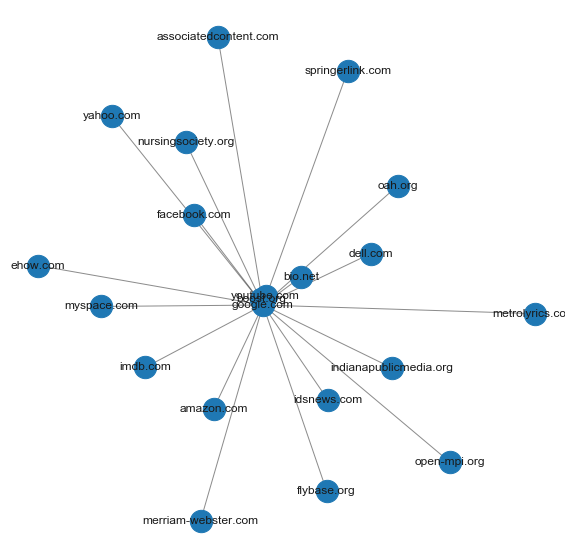

In [14]:
plt.figure(figsize=(10,10)) 
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500)

# edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.show()

In [15]:
# Looking at the weights of the edges in the sample graph for google.com
G.edges(data=True)

EdgeDataView([('ehow.com', 'google.com', {'weight': 3549}), ('bio.net', 'google.com', {'weight': 43976}), ('google.com', 'boost.org', {'weight': 49318}), ('google.com', 'youtube.com', {'weight': 27537}), ('google.com', 'dell.com', {'weight': 16733}), ('google.com', 'facebook.com', {'weight': 16520}), ('google.com', 'idsnews.com', {'weight': 9981}), ('google.com', 'oah.org', {'weight': 8679}), ('google.com', 'amazon.com', {'weight': 8448}), ('google.com', 'imdb.com', {'weight': 8104}), ('google.com', 'indianapublicmedia.org', {'weight': 7637}), ('google.com', 'nursingsociety.org', {'weight': 6355}), ('google.com', 'myspace.com', {'weight': 4497}), ('google.com', 'flybase.org', {'weight': 3893}), ('google.com', 'springerlink.com', {'weight': 3746}), ('google.com', 'open-mpi.org', {'weight': 3486}), ('google.com', 'merriam-webster.com', {'weight': 3145}), ('google.com', 'yahoo.com', {'weight': 3121}), ('google.com', 'metrolyrics.com', {'weight': 2700}), ('google.com', 'associatedcontent.c

From the above lines of code and result, the sample sub-graph was visualized for a select set of websites connected to google.com as the central graph. The graph is a weighted one, with the length of the edges reflective of the users that are shared between any 2 websites

**Creating the actual graph from entire dataset**

Next, the above steps would be carried out for the entire dataset, to convert the tabular format of data into a graph structure; where by the nodes of the graph would correspond to the websites and the edges between any 2 nodes would correspond to the number of users shared between those 2 websites.

In [16]:
site_data.head()

,from_url,to_url,user_count
0,youtube.com,google.com,212049
1,indianapublicmedia.org,wfiu.org,188708
2,drudgereport.com,google.com,57304
3,google.com,boost.org,49318
4,google.com,bio.net,43976


In [17]:
ls=[]
for i in range(len(site_data['from_url'])):
    ls.append(site_data['from_url'].iloc[i])

for i in range(len(site_data['to_url'])):
    ls.append(site_data['to_url'].iloc[i])

ls = list(set(ls))

In [18]:
#2. Add nodes
site_graph = nx.Graph() #Create a graph object called G

#Note: You can also try a spring_layout
pos=nx.spring_layout(site_graph) 
#nx.draw_networkx_nodes(G,pos,node_color='green',node_size=7500)
#plt.figure(figsize=(20,20)) 

#4. Add the edges (4C2 = 6 combinations)
#NOTE: You usually read this data in from some source
#To keep the example self contained, I typed this out
for i in range(len(site_data)):
    site_graph.add_edge(site_data['from_url'].iloc[i],site_data['to_url'].iloc[i],weight=site_data['user_count'].iloc[i])

In [19]:
# Inspecting the elements in the graph
site_graph.edges(data=True)

EdgeDataView([('youtube.com', 'google.com', {'weight': 27537}), ('youtube.com', 'myspace.com', {'weight': 76}), ('youtube.com', 'facebook.com', {'weight': 559}), ('youtube.com', 'lj-toys.com', {'weight': 16616}), ('youtube.com', 'youtube-nocookie.com', {'weight': 59}), ('youtube.com', 'tagged.com', {'weight': 7625}), ('youtube.com', 'iupui.edu', {'weight': 7113}), ('youtube.com', 'iue.edu', {'weight': 5883}), ('youtube.com', 'perezhilton.com', {'weight': 5837}), ('youtube.com', 'encyclopediadramatica.com', {'weight': 3906}), ('youtube.com', 'cracked.com', {'weight': 3322}), ('youtube.com', 'bloglines.com', {'weight': 2889}), ('youtube.com', 'huffingtonpost.com', {'weight': 2877}), ('youtube.com', 'footytube.com', {'weight': 2191}), ('youtube.com', 'mmo-champion.com', {'weight': 1915}), ('youtube.com', 'au2m8.com', {'weight': 1913}), ('youtube.com', 'thinkprogress.org', {'weight': 1896}), ('youtube.com', 'myyearbook.com', {'weight': 1813}), ('youtube.com', 'sugoideas.com', {'weight': 17

**EDA on the graph dataset**

The next step would be to perform exploratory analysis on the graph to understand the structure from a broader perspective. Before beginning with the modelling process, it is important to comprehend the structure of the graph that will be used as the input to the models, and the insights that can be derived from it. Performing EDA on graphs is slightly different to performing EDA on any tabular dataset, as the type of insights and characterisitcs that are exhibited by graphs are entirely different.

Identifying the **total number of nodes & edges** in the graph, and the **graph density** (defined to be the ratio of the number of edges with respect to the maximum possible edges)

In [20]:
#Basic graph stats
# Total number of nodes, edges
print("total number of nodes in the graph - " + str(len(site_graph.nodes)))
print("total number of edges in the graph - " + str(len(site_graph.edges)))

# Graph Density - defined to be the ratio of the number of edges with respect to the maximum possible edges
print("graph density - " + str(round(nx.density(site_graph)*100,3)) + '%')


total number of nodes in the graph - 7553
total number of edges in the graph - 9325
graph density - 0.033%


Identifying how well is the graph **connected**. A fully connected graph refers to a graph where all the nodes are connected to every other node in the structure.

In [21]:
# Identifying the connected graphs in the dataset
G = site_graph

ls = []
for i in nx.connected_components(G):
    x = G.subgraph(i).copy()
    ls.append(len(x.nodes))

x = pd.DataFrame(ls).reset_index()
x.columns = ['subgraph_no', 'nodes']
pd.DataFrame(x.groupby("nodes")['subgraph_no'].count()).reset_index()

,nodes,subgraph_no
0,2,543
1,3,66
2,4,28
3,5,13
4,6,3
5,7,4
6,9,1
7,11,1
8,17,2
9,5992,1


We see that there is one major subgraph that has a significant portion of connected nodes. We will filter out all other subgraphs as they are not connected, and hence will not be able to depict the relationship with other domains when generating embeddings.

In [22]:
# Picking the connected graph with highest number of nodes
for i in nx.connected_components(G):
    x = G.subgraph(i).copy()
    break
site_graph = x.copy()

After having removed all the subgraph with fewer number of nodes, we'll be left with one major connected subgraph. Identifying the standard characteristics exhibited by this graph.

In [23]:
#Basic graph stats
# Total number of nodes, edges
print("total number of nodes in the graph - " + str(len(site_graph.nodes)))
print("total number of edges in the graph - " + str(len(site_graph.edges)))

# Graph Density - defined to be the ratio of the number of edges with respect to the maximum possible edges
print("graph density - " + str(round(nx.density(site_graph)*100,3)) + '%')

# Eccentricity of a node is the max (shortest distance (weight) that exists between it and any other node in the data)
# The graph diameter is the max(eccentricity) - shortest distance between 2 most distance nodes in the graph
# In our context, the diameter refers to the number of user page visits that connect any 2 websites in our data
# This is an indication of how apart the graph nodes are situated 
shortest1 = nx.all_pairs_dijkstra_path_length(site_graph, weight="weight")
ecc = nx.eccentricity(site_graph, sp=dict(shortest1))
diam = nx.diameter(site_graph, e=ecc)
print("graph diameter - " + str(diam))

total number of nodes in the graph - 5992
total number of edges in the graph - 8412
graph density - 0.047%
graph diameter - 38747


Identifying the **distribution of the different node degrees** in the graph. The node degree of any node refers to the total number of edges connected to the node and is a very good indicator of how many connections every node in the graph has

In [24]:
ls = []
for i in site_graph.degree():
    ls.append(list(i))
node_degree = pd.DataFrame(ls)
node_degree.columns = ['website', 'no_of_nodes']

Text(0.5, 1.0, 'Log Distribution of Hits')

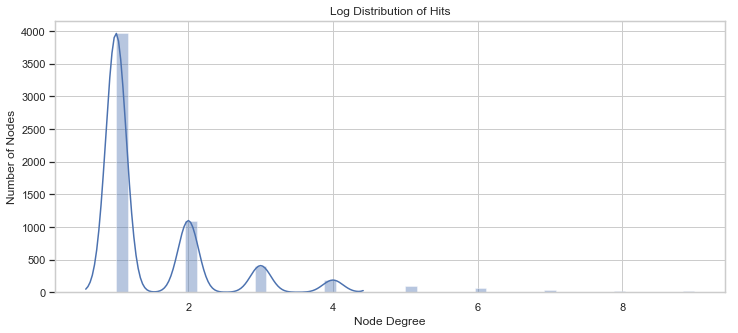

In [25]:
# Plotting the disrtribution of the data

data = website_hits['hits']
# Plotting hist without kde
plt.figure(figsize=(12, 5))
ax = sns.distplot(node_degree.loc[node_degree['no_of_nodes']<10,'no_of_nodes'], kde=False)
plt.ylabel('Number of Nodes' )
plt.xlabel('Node Degree')
# Creating another Y axis
second_ax = ax.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(node_degree.loc[node_degree['no_of_nodes']<np.percentile(node_degree['no_of_nodes'],95),'no_of_nodes'], ax=second_ax, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax.set_yticks([])

plt.title('Log Distribution of Hits')


It is evident that the majority of the websites in the graph have at most one connection with any other website in the data. This is also represented in the graph density score that was stated earlier and suggests that the nodes in the graph are connected to other nodes very sparsely.

Identifying the **centrality** exhibited by the graph. The centrality of a graph refers to the presence of one or more nodes that carry the potential of influencing the graph massively as they have a really large number of connections, spanning to almost all the other nodes. A graph with high centrality indicates that there is a single or a select few nodes that can be termed as the most important vertices and govern the relationships that exist between several other nodes.<br><br>
Here, we’ve compared three separate centrality algorithms to identify the presence of any central nodes:
- **Degree Centrality**: Represents the number of nodes connected to any node. A node will exhibit high centrality if it has a large degree.
- **Closeness Centrality**: Represents the average length between a node and its shortest distance to all other nodes. A node will exhibit high centrality if it is very close to several other nodes.
- **Betweenness Centrality**: Represents the number of times any node has been traversed and forms part of the shortest distance between any two other nodes. A node will exhibit high centrality if it is likely to be a part of traversed between any two nodes.


In [26]:
# Measuring the centrality of the graph

#degree centrality - the fraction of nodes any node is connected to (normalized by the total possible connections ie n-1)
func_dc = dict(nx.degree_centrality(site_graph))
deg_centr = pd.DataFrame(columns=('Website', 'Degree Centrality'))
j=0
for i in func_dc:
    deg_centr.loc[j] = [i] + [func_dc[i]]
    j=j+1
deg_centr = deg_centr.sort_values(by = "Degree Centrality", ascending=False).reset_index().iloc[:,1:]

#closeness_centrality
func_cc = dict(nx.closeness_centrality(site_graph))
cls_centr = pd.DataFrame(columns=('Website', 'Closeness Centrality'))
j=0
for i in func_cc:
    cls_centr.loc[j] = [i] + [func_cc[i]]
    j=j+1
cls_centr = cls_centr.sort_values(by = "Closeness Centrality", ascending=False).reset_index().iloc[:,1:]

#betweenness centrality
func_bc = dict(nx.betweenness_centrality(site_graph, weight='weight'))
btw_centr = pd.DataFrame(columns=('Website', 'Betweenness Centrality'))
j=0
for i in func_bc:
    btw_centr.loc[j] = [i] + [func_bc[i]]
    j=j+1
btw_centr = btw_centr.sort_values(by = "Betweenness Centrality", ascending=False).reset_index().iloc[:,1:]


In [27]:
# Top 5 central nodes from each centrality technique
central_nodes = pd.DataFrame(columns=("Degree Centrality", "Closeness Centrality", "Betweenness Centrality"))

for i in range(10):
    central_nodes.loc[i] = [deg_centr['Website'][i]] + [cls_centr['Website'][i]] + [btw_centr['Website'][i]] 

In [28]:
central_nodes

,Degree Centrality,Closeness Centrality,Betweenness Centrality
0,google.com,google.com,google.com
1,youtube.com,facebook.com,youtube.com
2,facebook.com,youtube.com,facebook.com
3,gravatar.com,stumbleupon.com,gravatar.com
4,digg.com,digg.com,freep.com
5,stumbleupon.com,indianapublicmedia.org,rightcelebrity.com
6,projectwonderful.com,crunchgear.com,stumbleupon.com
7,assoc-amazon.com,techcrunch.com,digg.com
8,burstbeacon.com,sidereel.com,webmasterworld.com
9,bing.com,bing.com,speedycpm.net


We observe that google, youtube and facebook occupy the central nodes using all the 3 centrality measures. This is indicative of the browsing behaviour of users.

In [29]:
# Degree Centrality score for the entire graph
V = len(deg_centr)
H = (V**2) - (3*V) + 2

max_centr_val = max(deg_centr['Degree Centrality'])
num = 0
for i in range(len(deg_centr)):
    tmp = abs(max_centr_val - deg_centr['Degree Centrality'][i])
    num = num + tmp

centrality_score = num *100 / H
print("Overall Degree Centrality Score - " + str(round(centrality_score, 4)) + "%")

Overall Degree Centrality Score - 0.0062%


Such a low score indicates that **there is minimal centrality being expressed by any single node in the graph**, which is desireable as we're looking to capture significant information from every node, and not let any single node dictate the relationships

**Modeling by tuning the set of hyperparameters**

The next step involves using the above graph data to achieve all the objectives that were set out to be achieved in this research. The steps performed in the following set of codes:

- We'll be tuning a node2vec model to generate the embeddings from the graph data.
- We'll be performing dimensionality reduction on the embeddings generated using 2 methods: linear (PCA), non-linear (T-SNE)
- We'll be clustering the final data to generate segments of domains using 3 techniques: K-means, hierarchical, DBSCAN
- We'll be evaluating every iteration of hyperparameters tuned to identify the most optimal set of hyperparameters using a custom scoring technique

The hyperparameters to be tuned in each technique is as follows:
    - Node2Vec : walk length = 10, no. of walks = 100, return parameter(p) = 2, in-out parameter (q) = 2, dimensions = [10, 20, 50]
    - PCA : components explaining 90% of variance
    - t-SNE : perplexity = 30, no. of iterations = 50, dimensions = [2, 5, 10, 20, 50], distance metric = pairwise eucledian
    - K-means clustering : max iterations = 50, no. of clusters = [5 to 50] in steps of 5, cluster init. = k-means ++
    - Hierarchical clustering: strategy = agglomerative, linkage : ward's, no. of clusters = [5 to 50] in steps of 5, affinity = eucledian
    - DBSCAN : epsilon = [0.1, 0.2, 0.5, 1, 2, 5], min. samples = [3, 5, 10, 20, 50, 100]

In [26]:
# the graph to be used - site_graph

In [27]:
# Functions and settings needed for t-sne
MACHINE_EPSILON = np.finfo(np.double).eps
perplexity = 30

def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

def _gradient_descent(obj_func, p0, args, it=0, n_iter=50,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    global tsne_kldiv
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
#         print("[t-SNE] Iteration %d: error = %.7f,"
#                       " gradient norm = %.7f"
#                       % (i + 1, error, grad_norm))
        
        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    tsne_kldiv = tsne_kldiv.append(pd.DataFrame([[n_components,best_error]], columns=tsne_kldiv.columns))
    print('[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe')
    return p

In [28]:
# Final results dataframe
final_results = pd.DataFrame(columns=('Node2vec Dimensions', 'Dimensionality Reduction Technique', 'Clustering Technique', 
                                     'Optiml Number of Clusters', 'Weighted Score'))

In [29]:
# Topline hyperparameters
node2vec_dim_list = [10, 20, 50]
dim_red_technique_list = ['None','PCA', 'T-SNE']
clustering_technique_list = ['K-Means', 'Hierarchical', 'DBSCAN']

In [34]:
# Iterating over all the possible hyperparameters for every technique

n2v_iter_no = 1
dim_red_iter_no = 1
clus_iter_no = 1
overall_iter_no = 1

for node2vec_dims in node2vec_dim_list:
    
    # Generating the embeddings using node2vec
    
    node2vec = Node2Vec(site_graph, dimensions=node2vec_dims, walk_length=10, num_walks=100, weight_key='weight', 
                        workers=1, p=2, q=2)
    
    ##Fitting model
    model = node2vec.fit(window=10, min_count=1)
    
    # Having generated the embeddings, let's put them in a dataframe and store them
    site_embed = pd.DataFrame()
    site_embed['site_domains'] = list(model.wv.vocab)
    site_embed = site_embed[site_embed['site_domains'].str.contains('[A-Za-z]')]
    site_embed.reset_index(inplace = True, drop=True)
    # Appending the embedddings to the dataframe
    ls = []
    
    for i in site_embed['site_domains']:
        ls.append(model[i])
    
    vector_df = pd.DataFrame(ls)
    site_embed = pd.concat([site_embed, vector_df], axis=1)
    
    for dim_red_technique in dim_red_technique_list:
        
        print("Starting dimensionality reduction iteration:" + str(dim_red_iter_no))
        
        #### ------------------------------------------------------------------------------------
        ## Using No dimensionality reduction
        if dim_red_technique == "None":
            site_embed_id = site_embed[['site_domains']]
            pca_df = site_embed.drop('site_domains', axis=1)
            
            #Adding column names to the components
            ls = []
            
            for i in range(len(pca_df.columns)):
                x = "PC"+str(i+1)
                ls.append(x)
                
            pca_df.columns = ls
            final_df = pd.concat([site_embed_id, pca_df], axis = 1)
            
        #### ------------------------------------------------------------------------------------
        ## Using PCA for dimensionality reduction
        if dim_red_technique == "PCA":
            pca = PCA(svd_solver='randomized', random_state=42)
            # Split the dataframes for the names of the country and their numerical attributes
            site_embed_id = site_embed[['site_domains']]
            site_embed_attr = site_embed.drop('site_domains', axis=1)
            # Doing the PCA on the attributes
            pca.fit(site_embed_attr)
            # Selecting components that explain 90% of the variance
            pca_again = PCA(0.9)
            # Apply the principal component transformation on our original dataset
            site_embed_pca2 = pca_again.fit_transform(site_embed_attr)
            #Creating a transpose so that the each column is properly arranged
            pca_df = pd.DataFrame(site_embed_pca2)
            
            #Adding column names to the components
            ls = []
            
            for i in range(len(pca_df.columns)):
                x = "PC"+str(i+1)
                ls.append(x)
                
            pca_df.columns = ls
            final_df = pd.concat([site_embed_id, pca_df], axis = 1)
            
        #### ------------------------------------------------------------------------------------
        ## Using t-sne for dimensionality reduction
        
        elif dim_red_technique == "T-SNE":
            # Creating a dataframe to capture KL Divergence
            tsne_kldiv = pd.DataFrame(columns=('TSNE Components', 'KL Divergence'))
            
            # Tuning the n_components hyperparameter to get the optimal number of components
            n_components_array = [2,5,10,20,50]
            for i in range(len(n_components_array)):
                n_components = n_components_array[i]
                X_embedded = fit(site_embed.drop('site_domains', axis=1))
            tsne_kldiv_final = pd.concat([tsne_kldiv.reset_index()], axis=1)[['TSNE Components', 'KL Divergence']]
            # Adding a scoring index that will penalize the tsne for more number of components
            # Score = KL Divergence + (TSNE Components/No of cols in original data)
            # The lower the score, the better our distribution
            tsne_kldiv_final['Score'] = tsne_kldiv_final['KL Divergence'] + (tsne_kldiv_final['TSNE Components']/len(site_embed.drop('site_domains', axis=1).columns))
            
            tsne_kldiv = pd.DataFrame(columns=('TSNE Components', 'KL Divergence'))
            # Identifying the best value for final number of components and performing the dimensionality reduction
            n_components = list(tsne_kldiv_final.loc[tsne_kldiv_final['Score'] == tsne_kldiv_final['Score'].min(), 'TSNE Components'])[0]
            X_embedded = fit(site_embed.drop('site_domains', axis=1))
            
            pca_df = pd.DataFrame(X_embedded)
            
            #Adding column names to the components
            ls = []
            
            for i in range(len(pca_df.columns)):
                x = "PC"+str(i+1)
                ls.append(x)
                
            pca_df.columns = ls
            final_df = pd.concat([site_embed_id, pca_df], axis = 1)
        
        print("Completed dimensionality reduction iteration:" + str(dim_red_iter_no))
        dim_red_iter_no = dim_red_iter_no + 1
        
        for clustering_technique in clustering_technique_list:
            
            print("Starting clustering iteration:" + str(clus_iter_no))
                
            #### ------------------------------------------------------------------------------------
            ## k-means clustering
            
            if clustering_technique == "K-Means":
                
                # Use the Silhouette Score to identify the optimum number of clusters
                from sklearn.metrics import silhouette_score
                sse_ = []
                for k in range(5, 51, 5):
                    kmeans = KMeans(n_clusters=k).fit(pca_df)
                    sse_.append([k, silhouette_score(pca_df, kmeans.labels_)])

                # Selecting the number of clusters with greatest silhouette score
                tmp_sse = pd.DataFrame(sse_)
                cluster_count = tmp_sse.loc[tmp_sse[1]==tmp_sse[1].max(), 0].values[0]

                # K-means using the optimum set of clusters
                model_clus2 = KMeans(n_clusters = cluster_count, max_iter=50,random_state = 50)
                model_clus2.fit(pca_df)

                dat4=pca_df.copy()
                dat4.index = pd.RangeIndex(len(dat4.index))
                dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
                dat_km.columns = np.append(dat_km.columns[:-1].values, 'ClusterID')
                cluster_df = pd.concat([site_embed_id, dat_km], axis = 1)
            
            #### ------------------------------------------------------------------------------------
            ## Hierarchical clustering
            
            elif clustering_technique == "Hierarchical":
                mergings = linkage(pca_df, method = "ward", metric='euclidean')
                
                # Use the Silhouette Score to identify the optimum number of clusters
                #First we'll do the silhouette score analysis
                sse_ = []
                for k in range(5, 51, 5):
                    clusterCut = pd.Series(cut_tree(mergings, n_clusters = k).reshape(-1,))
                    sse_.append([k, silhouette_score(pca_df, clusterCut)])
                
                # Selecting the number of clusters with greatest silhouette score
                tmp_sse = pd.DataFrame(sse_)
                cluster_count = tmp_sse.loc[tmp_sse[1]==tmp_sse[1].max(), 0].values[0]
                
                # Clustering using the optimum cluster count
                clusterCut = pd.Series(cut_tree(mergings, n_clusters = cluster_count).reshape(-1,))
                cluster_df = pd.concat([pca_df, clusterCut], axis=1)
                x = list(pca_df.columns)
                x.append("ClusterID")
                cluster_df.columns = x
                cluster_df = pd.concat([site_embed_id, cluster_df], axis = 1)
                
            #### ------------------------------------------------------------------------------------
            ## DBSCAN clustering
            
            elif clustering_technique == "DBSCAN":
                
                eps_values = [0.1, 0.2, 0.5, 1, 2, 5]
                min_sample_values = [3, 5, 10, 20, 50, 100]
                
                # Numpy array of all the cluster labels assigned to each data point 
                dbscan_res = pd.DataFrame(columns=('eps_value', 'min_samples', 'number_of_clusters', 'silhouette_score'))
                
                for i in eps_values:
                    for j in min_sample_values:
                        db_default = DBSCAN(eps = i, min_samples = j).fit(pca_df)
                        labels = db_default.labels_ 
                        try:
                            sil_score = silhouette_score(pca_df, labels)
                        except:
                            sil_score = 0
                        
                        dbscan_res.loc[i] = [i] + [j] + [len(set(labels))] + [sil_score]
                
                # We need to give preference to greater cluster count too along with silhouette score
                dbscan_res['importance'] = (dbscan_res['number_of_clusters'] **2) * dbscan_res['silhouette_score']
                
                # Picking the best hyperparameters
                eps_val = dbscan_res.sort_values(by = "importance", ascending=False).iloc[0, 0]
                min_samples_val = dbscan_res.sort_values(by = "importance", ascending=False).iloc[0, 1]
                
                # DBSCAN using best hyperparameters
                db_default = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(pca_df)
                labels = db_default.labels_ 
                
                dat4=pca_df.copy()
                dat4.index = pd.RangeIndex(len(dat4.index))
                dat_km = pd.concat([dat4, pd.Series(labels)], axis=1)
                dat_km.columns = np.append(dat_km.columns[:-1].values, 'ClusterID')
                cluster_df = pd.concat([site_embed_id, dat_km], axis = 1)
                
            print("Completed clustering iteration:" + str(clus_iter_no))
            
            clus_iter_no = clus_iter_no + 1
            
            
            #### ------------------------------------------------------------------------------------
            # Scoring the clusters
            # Within each cluster, we'll find the percent of domains that share a common user base by referring to our initial dataset
            res = pd.DataFrame(columns=('cluster_id', 'cluster_domains', 'website_overlap_score'))

            for i in cluster_df['ClusterID'].unique():
                site_data_tmp = site_data.copy()
                cluster_domains = cluster_df.loc[cluster_df['ClusterID']==i, 'site_domains'].values
                site_data_tmp['mapped_from_url'] = 0
                site_data_tmp['mapped_to_url'] = 0
                site_data_tmp.loc[site_data_tmp['from_url'].isin(cluster_domains), 'mapped_from_url'] = 1
                site_data_tmp.loc[site_data_tmp['to_url'].isin(cluster_domains), 'mapped_to_url'] = 1
                x = list(site_data_tmp.loc[(site_data_tmp['mapped_from_url']==1) & (site_data_tmp['mapped_to_url']==1),'from_url'].values)
                x = list(np.append(x, site_data_tmp.loc[(site_data_tmp['mapped_from_url']==1) & (site_data_tmp['mapped_to_url']==1),'to_url'].values))
                x = list(set(x))
                res.loc[i] = [i] + [len(cluster_domains)] + [len(x)/len(cluster_domains)]

            avd_domain_per_cluster = sum(res['cluster_domains'])/len(res) # average domains per cluster
            res['cluster_skew_score'] = 1 + abs(res['cluster_domains'] - avd_domain_per_cluster)/avd_domain_per_cluster # skewness score
            res['cluster_score'] = res['website_overlap_score']/res['cluster_skew_score']
            
            res.loc[res['cluster_id']==-1, 'cluster_score'] = 0 # Cases where clustering isn't done, mark those cluster scores as 0 
            wght_avg_scr = sum(res['cluster_domains']*res['cluster_score'])/sum(res['cluster_domains'])
            
            final_results.loc[overall_iter_no-1] = [node2vec_dims] + [dim_red_technique] + [clustering_technique] + [cluster_df['ClusterID'].nunique()] + [wght_avg_scr]
            
            print("Iterations added to the final result table:" +  str(overall_iter_no))
            
            overall_iter_no = overall_iter_no + 1

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [19:48<00:00, 11.88s/it]


Starting dimensionality reduction iteration:1
Completed dimensionality reduction iteration:1
Starting clustering iteration:1
Completed clustering iteration:1
Iterations added to the final result table:1
Starting clustering iteration:2
Completed clustering iteration:2
Iterations added to the final result table:2
Starting clustering iteration:3
Completed clustering iteration:3
Iterations added to the final result table:3
Starting dimensionality reduction iteration:2
Completed dimensionality reduction iteration:2
Starting clustering iteration:4
Completed clustering iteration:4
Iterations added to the final result table:4
Starting clustering iteration:5
Completed clustering iteration:5
Iterations added to the final result table:5
Starting clustering iteration:6
Completed clustering iteration:6
Iterations added to the final result table:6
Starting dimensionality reduction iteration:3
[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe
[t-SNE] Iteration Round Complete - KL Di

Computing transition probabilities:   0%|                                                     | 0/5992 [00:00<?, ?it/s]

Completed clustering iteration:9
Iterations added to the final result table:9


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [18:25<00:00, 11.05s/it]


Starting dimensionality reduction iteration:4
Completed dimensionality reduction iteration:4
Starting clustering iteration:10
Completed clustering iteration:10
Iterations added to the final result table:10
Starting clustering iteration:11
Completed clustering iteration:11
Iterations added to the final result table:11
Starting clustering iteration:12
Completed clustering iteration:12
Iterations added to the final result table:12
Starting dimensionality reduction iteration:5
Completed dimensionality reduction iteration:5
Starting clustering iteration:13
Completed clustering iteration:13
Iterations added to the final result table:13
Starting clustering iteration:14
Completed clustering iteration:14
Iterations added to the final result table:14
Starting clustering iteration:15
Completed clustering iteration:15
Iterations added to the final result table:15
Starting dimensionality reduction iteration:6
[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe
[t-SNE] Iteration Roun

Computing transition probabilities:   0%|                                                     | 0/5992 [00:00<?, ?it/s]

Completed clustering iteration:18
Iterations added to the final result table:18


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [18:14<00:00, 10.95s/it]


Starting dimensionality reduction iteration:7
Completed dimensionality reduction iteration:7
Starting clustering iteration:19
Completed clustering iteration:19
Iterations added to the final result table:19
Starting clustering iteration:20
Completed clustering iteration:20
Iterations added to the final result table:20
Starting clustering iteration:21
Completed clustering iteration:21
Iterations added to the final result table:21
Starting dimensionality reduction iteration:8
Completed dimensionality reduction iteration:8
Starting clustering iteration:22
Completed clustering iteration:22
Iterations added to the final result table:22
Starting clustering iteration:23
Completed clustering iteration:23
Iterations added to the final result table:23
Starting clustering iteration:24
Completed clustering iteration:24
Iterations added to the final result table:24
Starting dimensionality reduction iteration:9
[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe
[t-SNE] Iteration Roun

In [35]:
# Printing the dataframe, highlighting the best performing set of hyperparameters
def highlight_col(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #set by condition
    mask = df['Weighted Score'] == max(final_results['Weighted Score'])
    df.loc[mask, :] = 'background-color: yellow'
    df.loc[~mask,:] = 'background-color: ""'
    return df    

final_results.style.apply(highlight_col, axis=None)


,Node2vec Dimensions,Dimensionality Reduction Technique,Clustering Technique,Optiml Number of Clusters,Weighted Score
0,10,None,K-Means,50,0.285840
1,10,None,Hierarchical,50,0.305362
2,10,None,DBSCAN,2,0.410019
3,10,PCA,K-Means,40,0.327021
4,10,PCA,Hierarchical,50,0.284612
5,10,PCA,DBSCAN,5,0.200251
6,10,T-SNE,K-Means,45,0.381156
7,10,T-SNE,Hierarchical,50,0.387685
8,10,T-SNE,DBSCAN,1,0.000000
9,20,None,K-Means,50,0.294959


The weighted score above refers to the cluster confidence index (CCI) score that is indicative of how well the set of models were able to produce the final set of clusters of websites.

In [37]:
# Saving the results to a csv
# final_results.to_csv("final_results2.csv", index = False)

The set of hyperparameters identified to produce the best results are as follows:
    - Node2vec dimensions: 20<br>
    - Dimensionality reduction technique: T-SNE<br>
    - Clustering technique: K-Means clustering<br>

**Proceeding with visualizing the results using the best set of hyperparameters**

**Generating the embeddings using dim=20**

In [30]:
node2vec = Node2Vec(site_graph, dimensions=20, walk_length=10, num_walks=100, weight_key='weight', workers=1, p=2, q=2)

##Fitting model
model = node2vec.fit(window=10, min_count=1)

# Having generated the embeddings, let's put them in a dataframe and store them
site_embed = pd.DataFrame()
site_embed['site_domains'] = list(model.wv.vocab)
site_embed = site_embed[site_embed['site_domains'].str.contains('[A-Za-z]')]
site_embed.reset_index(inplace = True, drop=True)
# Appending the embedddings to the dataframe
ls = []

for i in site_embed['site_domains']:
    ls.append(model[i])

vector_df = pd.DataFrame(ls)
site_embed = pd.concat([site_embed, vector_df], axis=1)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.22s/it]


In [31]:
site_embed

,site_domains,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,vmware.com,-0.411984,0.399028,0.463646,-0.655823,-0.161646,0.259439,0.235156,-0.435738,0.212729,...,-0.218639,0.099214,-0.335123,-1.029182,0.304122,0.990461,-0.052672,0.826805,-1.197785,-0.180528
1,google.com,-0.322760,0.839935,-0.057970,-0.629175,-0.244704,0.004167,0.071131,-0.585568,0.145600,...,-0.352476,0.028236,-0.717828,-1.084051,0.314722,0.718592,-0.196525,1.124162,-0.449083,-0.547634
2,ew.com,-1.171172,0.472498,0.415813,-0.880930,-0.388399,-0.114850,0.130141,-0.698233,-0.050038,...,-0.273700,-0.442955,-0.423647,-1.118311,0.493306,0.743893,-0.255557,1.057134,-1.038972,-0.459929
3,seventeen.com,-0.510133,0.450874,0.336032,-0.211778,-0.278881,0.278984,-0.049674,-0.522279,0.141074,...,-0.618095,0.085893,-0.695644,-0.963363,0.233015,0.726562,-0.189771,1.241401,-0.978972,0.038716
4,boost.org,-1.439599,-0.822744,-0.850043,-0.139343,-1.284636,0.135897,-0.971394,-0.262335,-1.627023,...,-1.220194,-1.418203,-1.715976,-0.004335,-0.202918,2.317284,-0.112779,1.685658,-0.381852,-0.127803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,ditii.com,-0.627559,0.389334,-0.012287,-0.783360,-0.027479,0.068589,-0.239479,-0.458307,0.246581,...,-0.371901,-0.019529,-0.457678,-0.622256,0.019608,0.293432,-0.285407,0.865479,-0.799724,-0.331324
5988,greatschools.net,-0.371475,0.886504,0.528288,-0.647699,-0.299005,0.444293,-0.341215,-0.330401,0.708893,...,-0.611953,-0.180788,-0.755792,-1.260927,0.429501,0.405022,-0.103263,1.142174,-1.099689,-0.304714
5989,movie-moron.com,-1.631259,-0.201246,-1.259339,1.387877,0.292103,-0.308160,-0.921084,1.705369,-0.820547,...,0.111060,-0.511485,0.829864,1.044755,0.567047,0.493847,0.364877,-0.237034,-1.438169,0.934391
5990,info.com,-0.443435,0.421962,-0.031381,-1.036975,-0.072685,0.384569,0.110116,-0.345457,-0.134114,...,-0.388991,0.038496,-0.903419,-0.731710,0.342623,0.813604,-0.578658,0.724441,-0.873256,-0.256871


In order to intuitively understand how well the embeddings have been generated, we will identify the closest website to any particular website and check how relevant they are. We will define cosine similarity as the distance metric to calculate the closest websites to any website on the vector space

In [32]:
def cosine_similarities(site_domain, embedding_df):
    
    vec = embedding_df[embedding_df['site_domains']==site_domain]
    vec = vec.drop('site_domains', axis=1)
    vec = np.array(vec)
    
    vec_all_df = embedding_df[embedding_df['site_domains']!=site_domain]
    vec_all = vec_all_df.drop('site_domains', axis=1)
    vec_all = np.array(vec_all)    
    
    norm = np.linalg.norm(vec)
    all_norms = np.linalg.norm(vec_all, axis=1)
    dot_products = np.dot(vec_all, vec.T) ##transposing to do a matrix multiplication of XxA and AxY
    similarities = dot_products.T / (norm * all_norms)
    
    
    vec_all_df_reset = vec_all_df.reset_index()
    vec_all_df_reset = vec_all_df_reset['site_domains']

    vec_all_df_reset_sim = pd.concat([vec_all_df_reset, pd.DataFrame(similarities.T)], axis=1)
    vec_all_df_reset_sim.columns = ['site_domains','cos_sim']
    
    return vec_all_df_reset_sim



def most_similar(site_domain, embedding_df, top_n):
    
    sim_scores = cosine_similarities(site_domain, embedding_df)
    
    return sim_scores.nlargest(top_n,'cos_sim')

The “economist.com” website is an e-magazine that discusses economic, financial, and political news across the globe. To evaluate the quality of the embeddings, 11 websites with an embedding vector closest to the vector representing “economist.com” is computed below. 

In [38]:
# Using the function most_similar to get top_n most similar sitedomains using cosine similarity

# sim_scores = cosine_similarities("mirror.co.uk", final_embed_df)
# sim_scores.nlargest(10,'cos_sim')

most_similar("economist.com", site_embed, 11)

,site_domains,cos_sim
4126,marketwatch.com,0.960779
2446,insidehighered.com,0.929013
3902,thriftyfun.com,0.925488
4049,entrepreneur.com,0.923151
3269,tiaa-cref.org,0.881433
3686,ritholtz.com,0.867428
455,chronicle.com,0.857270
5436,quote.com,0.839470
4048,entrepreneurenespanol.com,0.835272
3666,bankrate.com,0.794904


The assessment for the quality of embeddings generated is quite positive. The website embeddings closest to the economist website are all related to economic and finance categories of websites, hence fall in a bracket similar to the economist website. This is a fair indication that the node2vec model implemented on the dataset has done a satisfactory job in representing the relationships between the websites on a vector space.

**Dimensionality Reduction using T-SNE**

To help get a deeper understanding of the quality of the output produced by the models, the below sets of codes have been written. Here, a set of websites belonging to five separate website categories, i.e. news blogs, business/finance/economic blogs, sports blogs, music blogs, and tech blogs, were picked from the dataset and their plotted on the vector space as generated by the node2vec algorithm above. <br><br>
In order to enable the data points to be visualized, a t-SNE algorithm with 2 components would be applied to bring down the 20-D embedding to a 2-D representation that would allow it to be represented on an x-y scale.

In [41]:
site_embed_id = site_embed[['site_domains']]

# Creating a dataframe to capture KL Divergence
tsne_kldiv = pd.DataFrame(columns=('TSNE Components', 'KL Divergence'))

# Tuning the n_components hyperparameter to get the optimal number of components
n_components_array = [2]
for i in range(len(n_components_array)):
    n_components = n_components_array[i]
    X_embedded = fit(site_embed.drop('site_domains', axis=1))
tsne_kldiv_final = pd.concat([tsne_kldiv.reset_index()], axis=1)[['TSNE Components', 'KL Divergence']]
# Adding a scoring index that will penalize the tsne for more number of components
# Score = KL Divergence + (TSNE Components/No of cols in original data)
# The lower the score, the better our distribution
tsne_kldiv_final['Score'] = tsne_kldiv_final['KL Divergence'] + (tsne_kldiv_final['TSNE Components']/len(site_embed.drop('site_domains', axis=1).columns))

tsne_kldiv = pd.DataFrame(columns=('TSNE Components', 'KL Divergence'))
# Identifying the best value for final number of components and performing the dimensionality reduction
n_components = list(tsne_kldiv_final.loc[tsne_kldiv_final['Score'] == tsne_kldiv_final['Score'].min(), 'TSNE Components'])[0]
X_embedded = fit(site_embed.drop('site_domains', axis=1))

pca_df = pd.DataFrame(X_embedded)

#Adding column names to the components
ls = []

for i in range(len(pca_df.columns)):
    x = "PC"+str(i+1)
    ls.append(x)

pca_df.columns = ls
final_df = pd.concat([site_embed_id, pca_df], axis = 1)

[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe
[t-SNE] Iteration Round Complete - KL Divergence added to Dataframe


In [179]:
final_df = pd.concat([site_embed_id, pca_df], axis = 1)
final_df

,site_domains,PC1,PC2
0,vmware.com,-1.117279,-3.059599
1,google.com,-1.591165,0.115455
2,ew.com,1.612223,-0.681657
3,seventeen.com,-2.050130,-0.703128
4,boost.org,-3.679206,12.200549
...,...,...,...
5987,ditii.com,-3.632228,0.048873
5988,greatschools.net,-0.269214,-3.509040
5989,movie-moron.com,-3.719023,7.854863
5990,info.com,-3.180238,-1.169860


In [180]:
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
final_df = pd.concat([final_df['site_domains'],pd.DataFrame(scaler.fit_transform(final_df[['PC1', 'PC2']]))], axis=1)
final_df.columns = ['site_domains', 'PC1', 'PC2']

Having generated the 2-D vector representation for all the websites in the graph, the next step would be identifying the websites that fall in the 5 different website categories mentioned above.

In [186]:
embedding_viz = pd.DataFrame(columns=('website_category', 'avg_comp1', 'avg_comp2'))

In [270]:
# Adding Business Domains to the dataframe
biz_blogs = ['entrepreneur.com', 'marketwatch.com', 'quote.com', 'economist.com', 'insidehighered.com',
                  'entrepreneurenespanol.com', 'ritholtz.com', 'tiaa-cref.org']
tmp = final_df.loc[final_df['site_domains'].isin(biz_blogs), :].reset_index()
tmp['cat'] = 'Business & Economic Blogs'

embedding_viz.loc[0] = ["Business, Finance and Economic Blogs"] + [tmp['PC1'].mean()] + [tmp['PC2'].mean()]

# Adding Sport Domains to the dataframe
sport_blogs = ['moondogsports.com', 'digitalsports.com', 'sportsagentblog.com', 
               'gopsusports.com', 'bvonsports.com', 'sportingnews.com', 'butlersports.com']
tmp = final_df.loc[final_df['site_domains'].isin(sport_blogs), :].reset_index()
tmp['cat'] = 'Sports Blogs'

embedding_viz.loc[1] = ["Sports Blogs"] + [tmp['PC1'].mean()] + [tmp['PC2'].mean()]

# Adding News Domains to the dataframe
news_blogs = ['tmnews.com', 'newsnidea.com', 'realitynewsonline.com', 'detroitnews.com', 'abs-cbnnews.com', 
               'marketnewsvideo.com', 'probablybadnews.com']
tmp = final_df.loc[final_df['site_domains'].isin(news_blogs), :].reset_index()
tmp['cat'] = 'News Blogs'

embedding_viz.loc[2] = ["News Blogs"] + [tmp['PC1'].mean()] + [tmp['PC2'].mean()]

# Adding Music Domains to the dataframe
music_blogs = ['fratmusic.com','hiphopmusicdotcom.com', 'rnbmusicblog.com', 'ultramusicfestival.com', 'emusic.com']
tmp = final_df.loc[final_df['site_domains'].isin(music_blogs), :].reset_index()
tmp['cat'] = 'Music Blogs'

embedding_viz.loc[3] = ["Music Blogs"] + [tmp['PC1'].mean()] + [tmp['PC2'].mean()]

# Adding Tech Domains to the dataframe
tech_blogs = [ 'techforless.com', 'ivytech.edu', 'techpp.com', 'extremetech.com', 'honda-tech.com', 
              'technorati.com']
tmp = final_df.loc[final_df['site_domains'].isin(tech_blogs), :].reset_index()
tmp['cat'] = 'Tech Blogs'

embedding_viz.loc[4] = ["Tech Blogs"] + [tmp['PC1'].mean()] + [tmp['PC2'].mean()]


embedding_viz

,website_category,avg_comp1,avg_comp2
0,"Business, Finance and Economic Blogs",0.224789,0.688687
1,Sports Blogs,0.334437,0.229840
2,News Blogs,0.778762,0.423247
3,Music Blogs,0.420973,0.720234
4,Tech Blogs,0.099910,0.320679


Having identified a select set of websites that fall in each of the 5 categories above, an average of all the data points is computed which would be representative of the website category on the vector space. These averages are then plotted on the 2-D vector space to understand where each of the categories falls

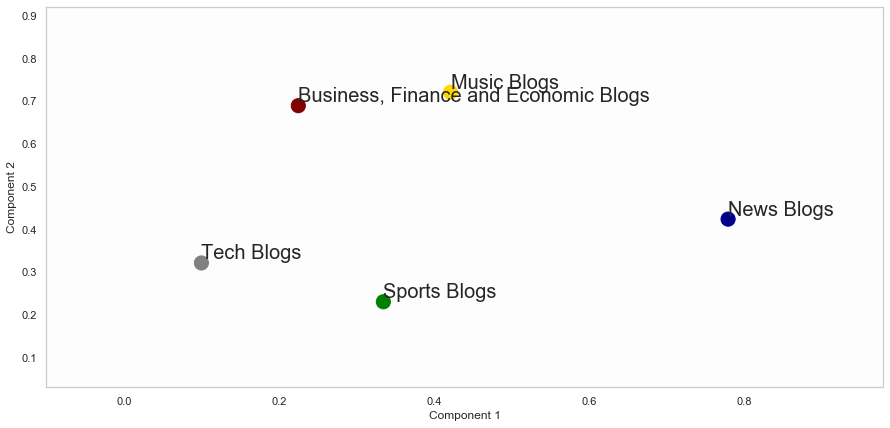

In [271]:
# Plotting the website category plot
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(embedding_viz['avg_comp1'], embedding_viz['avg_comp2'], s=200, color=['maroon','green','darkblue', 'gold', 'grey'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.xlim(min(embedding_viz['avg_comp1'])-0.2, max(embedding_viz['avg_comp1'])+0.2)
plt.ylim(min(embedding_viz['avg_comp2'])-0.2, max(embedding_viz['avg_comp2'])+0.2)
# Hide grid lines
ax.grid(False)
ax.set_facecolor('xkcd:pale grey')
for i, txt in enumerate(embedding_viz['website_category']):
    ax.annotate(txt, (embedding_viz['avg_comp1'][i], embedding_viz['avg_comp2'][i]), size=20, horizontalalignment='left', verticalalignment='bottom')

From the above viz, it is evident that the relationships between the websites have been capture pretty well by the node2vec algorithm. The different website categories have found a separate space on the vector space. In order to understand how well these websites can be separable from one another, the next viz below plots the individual websites on the vector space.

In [272]:
tmp1 = final_df.loc[final_df['site_domains'].isin(biz_blogs), :].reset_index()
tmp1['cat'] = 'Business Blogs'

tmp2 = final_df.loc[final_df['site_domains'].isin(music_blogs), :].reset_index()
tmp2['cat'] = 'Music Blogs'

tmp3 = final_df.loc[final_df['site_domains'].isin(sport_blogs), :].reset_index()
tmp3['cat'] = 'Sport Blogs'

tmp4 = final_df.loc[final_df['site_domains'].isin(news_blogs), :].reset_index()
tmp4['cat'] = 'News Blogs'

tmp5 = final_df.loc[final_df['site_domains'].isin(tech_blogs), :].reset_index()
tmp5['cat'] = 'Tech Blogs'

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4, tmp5])[['site_domains', 'PC1', 'PC2', 'cat']]
tmp = tmp.reset_index()[['site_domains', 'PC1', 'PC2', 'cat']]

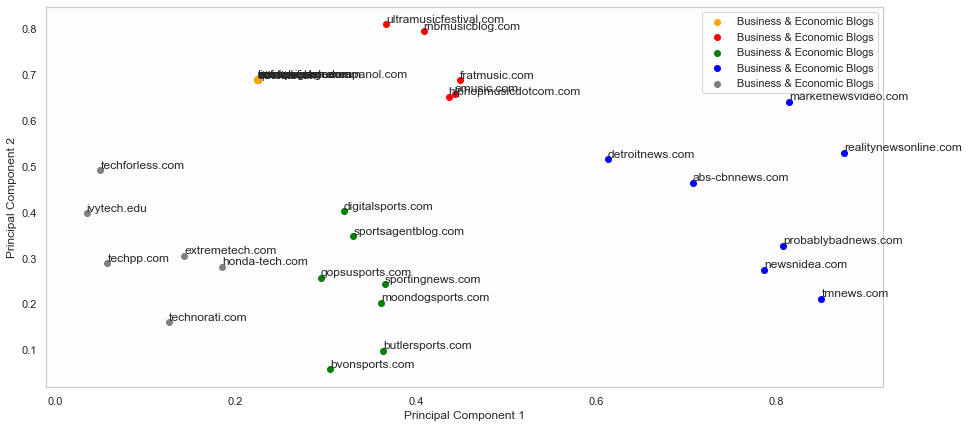

In [273]:
# Plotting for individual website categories
fig, ax = plt.subplots(figsize=(15,7))
#ax.scatter(tmp.loc[tmp['cat']=='Sport Blogs', 'PC1'], tmp.loc[tmp['cat']=='Sport Blogs', 'PC2'], s=150, c='blue', label = 'Sport Blogs')
ax.scatter(tmp.loc[tmp['cat']=='Business Blogs','PC1'], tmp.loc[tmp['cat']=='Business Blogs','PC2'], c='orange', label = 'Business & Economic Blogs')
ax.scatter(tmp.loc[tmp['cat']=='Music Blogs','PC1'], tmp.loc[tmp['cat']=='Music Blogs','PC2'], c='red', label = 'Business & Economic Blogs')
ax.scatter(tmp.loc[tmp['cat']=='Sport Blogs','PC1'], tmp.loc[tmp['cat']=='Sport Blogs','PC2'], c='green', label = 'Business & Economic Blogs')
ax.scatter(tmp.loc[tmp['cat']=='News Blogs','PC1'], tmp.loc[tmp['cat']=='News Blogs','PC2'], c='blue', label = 'Business & Economic Blogs')
ax.scatter(tmp.loc[tmp['cat']=='Tech Blogs','PC1'], tmp.loc[tmp['cat']=='Tech Blogs','PC2'], c='grey', label = 'Business & Economic Blogs')
plt.legend(loc='top right')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
#plt.xlim(min(tmp['PC1'])-0.2, max(tmp['PC1'])+0.2)
#plt.ylim(min(tmp['PC2'])-0.2, max(tmp['PC2'])+0.2)
# Hide grid lines
ax.grid(False)
ax.set_facecolor('xkcd:pale grey')
for i, txt in enumerate(tmp['site_domains']):
    ax.annotate(txt, (tmp['PC1'][i], tmp['PC2'][i]), size=12, horizontalalignment='left', verticalalignment='bottom')

In [275]:
# tmp.to_csv("cluster_plot.csv", index=False)

We observe that our model is able to generate intuitive vector representations for the websites. The example above shows a sample of food and tech blogs plotted on 2 principal components to check how well they have been represented. The visualization shows that the model was able to segregate the data such that websites of similar categories appear in form of clusters. This is representative of the behaviour of users online, and the above dataset can be used to generate clusters of websites which can be used in digital advertising for contextual ad targeting.

**Clustering the dataset using the K-means approach (k=45)**

The final model in the set is the k-means clustering that produces 45 clusters. The below lines of code perform the clustering, and demonstrate how the scores for the individual cluster look like.

In [100]:
# Use the Silhouette Score to identify the optimum number of clusters
from sklearn.metrics import silhouette_score
sse_ = []

# K-means using the optimum set of clusters
model_clus2 = KMeans(n_clusters = 45, max_iter=50,random_state = 50)
model_clus2.fit(pca_df)

dat4=pca_df.copy()
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = np.append(dat_km.columns[:-1].values, 'ClusterID')
cluster_df = pd.concat([site_embed_id, dat_km], axis = 1)

In [101]:
# Checking the individual cluster scores
# Within each cluster, we'll find the percent of domains that share a common user base by referring to our initial dataset
res = pd.DataFrame(columns=('cluster_id', 'cluster_domains', 'website_overlap_score'))

for i in cluster_df['ClusterID'].unique():
    site_data_tmp = site_data.copy()
    cluster_domains = cluster_df.loc[cluster_df['ClusterID']==i, 'site_domains'].values
    site_data_tmp['mapped_from_url'] = 0
    site_data_tmp['mapped_to_url'] = 0
    site_data_tmp.loc[site_data_tmp['from_url'].isin(cluster_domains), 'mapped_from_url'] = 1
    site_data_tmp.loc[site_data_tmp['to_url'].isin(cluster_domains), 'mapped_to_url'] = 1
    x = list(site_data_tmp.loc[(site_data_tmp['mapped_from_url']==1) & (site_data_tmp['mapped_to_url']==1),'from_url'].values)
    x = list(np.append(x, site_data_tmp.loc[(site_data_tmp['mapped_from_url']==1) & (site_data_tmp['mapped_to_url']==1),'to_url'].values))
    x = list(set(x))
    res.loc[i] = [i] + [len(cluster_domains)] + [len(x)/len(cluster_domains)]

avd_domain_per_cluster = sum(res['cluster_domains'])/len(res) # average domains per cluster
res['cluster_skew_score'] = 1 + abs(res['cluster_domains'] - avd_domain_per_cluster)/avd_domain_per_cluster # skewness score
res['cluster_score'] = res['website_overlap_score']/res['cluster_skew_score']
res

,cluster_id,cluster_domains,website_overlap_score,cluster_skew_score,cluster_score
23,23.0,142.0,0.415493,1.066422,0.389614
34,34.0,61.0,0.229508,1.541889,0.148849
15,15.0,135.0,0.148148,1.013852,0.146124
14,14.0,115.0,0.017391,1.136348,0.015305
1,1.0,136.0,0.169118,1.021362,0.165581
37,37.0,108.0,0.074074,1.188919,0.062304
16,16.0,146.0,0.047945,1.096462,0.043727
5,5.0,152.0,0.144737,1.141522,0.126793
17,17.0,203.0,0.088670,1.524533,0.058162
38,38.0,110.0,0.045455,1.173899,0.038721


The above dataframe represents all the clusters indvidually and their features. The final process of clustering resulted in 45 sets of websites. Each of these clusters consists of websites that share a very common user base. Therefore, each of these groups of websites can be targeted as separate segments for different advertisers based on the relevancy towards specific clusters.